# **Importing Libraries**

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize  # Used for resizing images
from skimage.io import imread, imshow  # For reading and displaying images
from tensorflow import keras  # For building and managing neural networks


# **Pure Images from Dataset**

Shape of training data (images): (1328, 512, 512, 3)
Data type of images: uint8


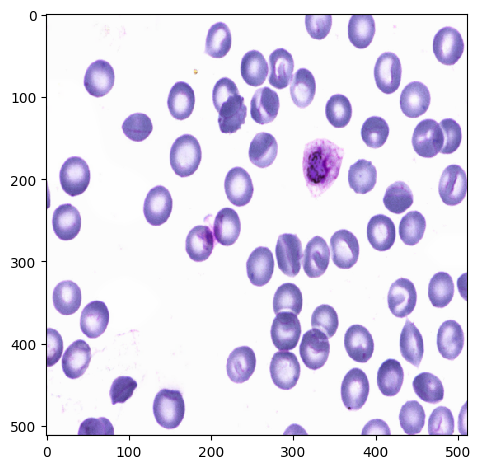

In [3]:
# Define the image dimensions
row = 512  # Height of the image
columns = 512  # Width of the image

# Load the training images from the directory
train_data_path = '/kaggle/input/blooddata/Original'  # Path to training images
training_images = os.listdir(train_data_path)  # List of image filenames
training_images.sort()  # Sort images for consistency

# Initialize an array to hold the images
# X: A numpy array to store all images, with shape (number_of_images, height, width, channels)
X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)  # Initialize with zeros

# Loop through the images, resize them, and store them in the X array
index = 0
for x in training_images:
    path = os.path.join(train_data_path, x)  # Get the full path of the image
    image = imread(path)  # Read the image from the path
    image = resize(image, (row, columns), mode='constant', preserve_range=True)  # Resize the image
    X[index] = image  # Store the resized image in the X array
    index += 1  # Increment index

# Output the shape of the loaded images array
print("Shape of training data (images):", X.shape)

# Check the data type of the images array
print("Data type of images:", X.dtype)

# Visualize the first image in the dataset to verify
imshow(X[0])
plt.show()  # Display the image

# **Pure masks from dataset**

Shape of training data (masks): (1328, 512, 512, 3)
Data type of masks: uint8


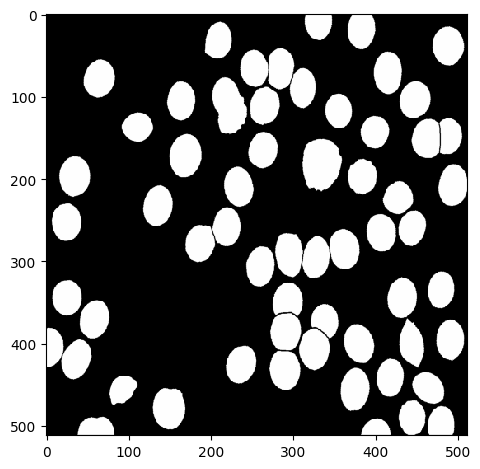

In [4]:
# Define the path to the mask images
train_data_path = '/kaggle/input/blooddata/Mask'  # Path to the mask images
training_masks = os.listdir(train_data_path)  # List of mask filenames
training_masks.sort()  # Sort masks for consistency

# Initialize an array to hold the mask images
# y: A numpy array to store all masks, with shape (number_of_masks, height, width, channels)
y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)  # Initialize with zeros

# Loop through the mask images, resize them, and store them in the y array
index = 0
for x in training_masks:
    path = os.path.join(train_data_path, x)  # Get the full path of the mask
    image = imread(path)  # Read the mask from the path
    image = resize(image, (row, columns), mode='constant', preserve_range=True)  # Resize the mask
    y[index] = image  # Store the resized mask in the y array
    index += 1  # Increment index

# Output the shape of the loaded masks array
print("Shape of training data (masks):", y.shape)

# Check the data type of the masks array
print("Data type of masks:", y.dtype)

# Visualize the first mask in the dataset to verify
imshow(y[0])
plt.show()  # Display the mask

# **Splitting into 80:20 ratio**

In [5]:
# Import necessary library for splitting the dataset
import numpy as np
from sklearn.model_selection import train_test_split  # Used to split the dataset into training and testing sets

# Split the dataset into 80% training and 20% testing
# X: Input images, y: Corresponding masks (labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Subheading: Verifying the Split
# Print the shapes of the training and testing data to verify the split
print("Training images shape:", X_train.shape)
print("Training masks shape:", y_train.shape)
print()
print("Testing images shape:", X_test.shape)
print("Testing masks shape:", y_test.shape)

Training images shape: (1062, 512, 512, 3)
Training masks shape: (1062, 512, 512, 3)

Testing images shape: (266, 512, 512, 3)
Testing masks shape: (266, 512, 512, 3)


# **Visualizing Training and Testing Images**

Displaying the first training image:


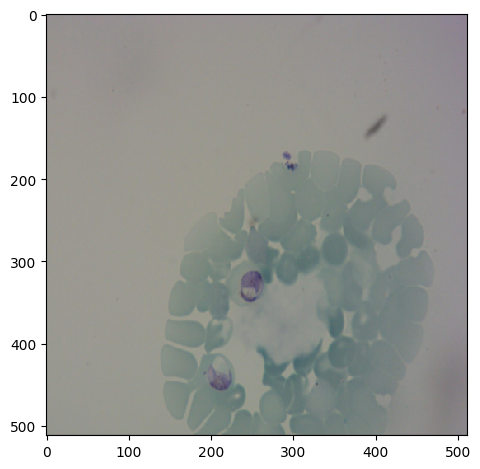

Displaying the corresponding mask for the first training image:


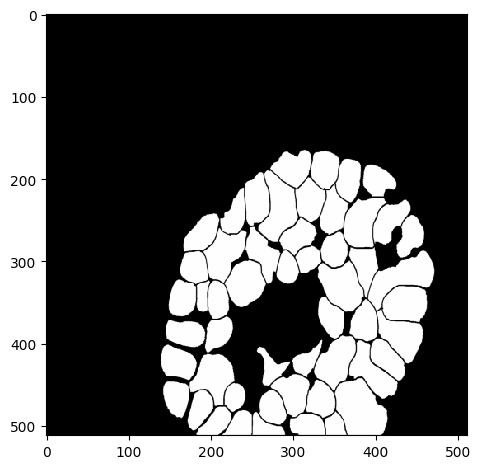

In [6]:
# Visualize the first image in the training set
# X_train contains the training images
print("Displaying the first training image:")
imshow(X_train[0])  # Display the first training image
plt.show()  # Show the plot

# Visualize the corresponding mask (label) for the first image
# y_train contains the corresponding masks for the training images
print("Displaying the corresponding mask for the first training image:")
imshow(y_train[0])  # Display the first mask
plt.show()  # Show the plot

Displaying the first testing image:


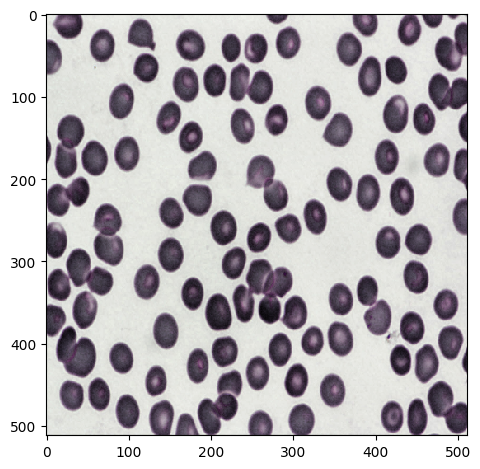

Displaying the corresponding mask for the first testing image:


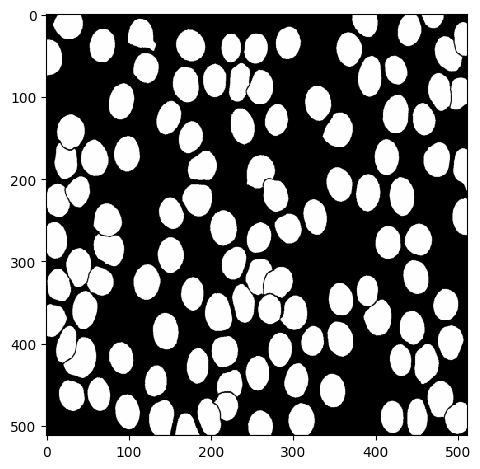

In [7]:
# Visualize the first image in the testing set
# X_test contains the testing images
print("Displaying the first testing image:")
imshow(X_test[0])  # Display the first testing image
plt.show()  # Show the plot

# Visualize the corresponding mask (label) for the first image in the test set
# y_test contains the corresponding masks for the testing images
print("Displaying the corresponding mask for the first testing image:")
imshow(y_test[0])  # Display the first testing mask
plt.show()  # Show the plot

In [8]:
# Convert the masks in the training set (y_train) to boolean type
# This is often done for binary masks, where 0 represents background and 1 represents the object
y_train = y_train.astype('bool')

# Print the data type of the training masks after conversion to confirm
print("Data type of training masks after conversion:", y_train.dtype)

Data type of training masks after conversion: bool


# **Importing Necessary Libraries**

In [9]:
# Keras and TensorFlow are used for building and training the deep learning model
# Keras models and layers provide a high-level interface for defining and training models

# Importing necessary libraries from Keras for model building and training
from keras.models import Model, load_model  # Model allows us to define custom models, load_model for saving/loading models
from keras.layers import Input  # Input layer for defining input shape of the model
from keras.layers import Dropout, Lambda  # Dropout: for regularization, Lambda: to wrap custom functions as layers
from keras.layers import Conv2D, Conv2DTranspose  # Conv2D: for convolutional layers, Conv2DTranspose: for deconvolution (upsampling)
from keras.layers import MaxPooling2D  # MaxPooling2D: for downsampling the feature maps
from keras.layers import concatenate  # concatenate: to merge different layers, especially in U-Net architecture
from keras.callbacks import EarlyStopping, ModelCheckpoint  # EarlyStopping: to stop training if performance stops improving, ModelCheckpoint: to save the best model
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, add, multiply, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
# Importing backend functions from TensorFlow
import tensorflow.keras.backend as K  # Backend utility functions, often used in custom loss functions or metrics
import tensorflow as tf  # TensorFlow framework, which Keras is built on

# **Metrics for training + validation**

In [10]:
# The Dice Coefficient and Jaccard Index (Intersection over Union, IoU) are commonly used metrics
# in segmentation tasks to evaluate the overlap between predicted masks and ground truth masks.

# Dice Coefficient: Measures the similarity between two samples (higher is better)
# Formula: 2 * (|A ∩ B|) / (|A| + |B|)

def dice_coef(a, b):
    # a: Ground truth mask
    # b: Predicted mask

    hi = a  # Ground truth mask
    pred = b  # Predicted mask

    # Flatten the masks to make the operation element-wise
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator (intersection between ground truth and prediction)
    upper_part = 2 * tf.keras.backend.sum(hi * pred)  # Intersection is multiplied by 2

    # Calculate the denominator (sum of the ground truth and prediction)
    lower_part = tf.keras.backend.sum(hi + pred)

    # Dice Coefficient is the ratio of intersection over the total area
    dice = upper_part / lower_part

    return dice

# Jaccard Index (IoU): Measures the intersection over the union (higher is better)
# Formula: |A ∩ B| / (|A ∪ B|)

def jaccard_index(a, b):
    # a: Ground truth mask
    # b: Predicted mask

    hi = a  # Ground truth mask
    pred = b  # Predicted mask

    # Flatten the masks to make the operation element-wise
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator (intersection between ground truth and prediction)
    numerator = tf.keras.backend.sum(hi * pred)  # Intersection

    # Calculate the denominator (union of ground truth and prediction)
    denominator = tf.keras.backend.sum(hi + pred - hi * pred)  # Union

    # Jaccard Index is the ratio of intersection over union
    iou = numerator / denominator

    return iou

# **Attention U-net**

In [11]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    # Extract number of channels based on data format (channels_last means [height, width, channels])
    if data_format == 'channels_last':
        in_channel = K.int_shape(down_layer)[-1]
    else:
        in_channel = K.int_shape(down_layer)[1]

    # Upsample the input feature map from the down-sampling layer
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    # Apply attention block between the upsampled feature map and the corresponding encoder feature map
    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    # Concatenate the upsampled feature map with the attended feature map based on data format
    if data_format == 'channels_last':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=-1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))

    # Perform the concatenation
    concate = my_concat([up, layer])
    return concate

def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    # 1x1 convolution on the encoder feature map to reduce channels
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), data_format=data_format)(x)
    print(f"theta_x shape: {K.int_shape(theta_x)}")

    # 1x1 convolution on the decoder feature map to match dimensions
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), data_format=data_format)(g)
    print(f"phi_g shape: {K.int_shape(phi_g)}")

    # Add the two feature maps and apply ReLU activation
    f = Activation('relu')(add([theta_x, phi_g]))

    # Reduce to a single-channel attention map using a 1x1 convolution
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), data_format=data_format)(f)

    # Apply sigmoid to get the attention weights
    rate = Activation('sigmoid')(psi_f)

    # Multiply input feature map with attention weights
    att_x = multiply([x, rate])

    return att_x

# Attention U-Net architecture
def att_unet(img_w, img_h, n_label, data_format='channels_last'):
    # Define the input layer with image dimensions (img_w, img_h, 3)
    inputs = Input((img_w, img_h, 3))  # Change to channels_last format
    x = inputs

    depth = 4  # Number of downsampling layers (encoder depth)
    features = 64  # Initial number of filters for the first layer
    skips = []  # To store the feature maps for skip connections
    
    # Encoder path (downsampling)
    for i in range(depth):
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)  # Store skip connection feature map
        x = MaxPooling2D((2, 2), data_format='channels_last')(x)
        features = features * 2  # Double the number of filters after each downsampling

    # Bottleneck (bridge between encoder and decoder)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    # Decoder path (upsampling)
    for i in reversed(range(depth)):
        features = features // 2  # Halve the number of filters as we upsample
        x = attention_up_and_concate(x, skips[i], data_format=data_format)  # Apply attention and concatenate
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    # Final 1x1 convolution to map to the desired number of output labels
    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    # Sigmoid activation to get the final output probabilities
    conv7 = Activation('sigmoid')(conv6)

    # Create the model with inputs and outputs
    model = Model(inputs=inputs, outputs=conv7)

    # Compile the model with Adam optimizer and binary crossentropy loss
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])
    
    return model

# Create the Attention U-Net model with input dimensions and 3 output labels
model = att_unet(512, 512, 3)
model.summary()  # Print model summary to inspect the architecture


theta_x shape: (None, 64, 64, 256)
phi_g shape: (None, 64, 64, 256)
theta_x shape: (None, 128, 128, 128)
phi_g shape: (None, 128, 128, 128)
theta_x shape: (None, 256, 256, 64)
phi_g shape: (None, 256, 256, 64)
theta_x shape: (None, 512, 512, 32)
phi_g shape: (None, 512, 512, 32)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 31,902,759 (121.70 MB)

 Trainable params: 31,902,759 (121.70 MB)

 Non-trainable params: 0 (0.00 B)

# **Checking input format before model fit**

In [12]:
# Print the data types of the training images and masks before conversion
print("Data type of X_train (images) before conversion:", X_train.dtype)
print("Data type of y_train (masks) before conversion:", y_train.dtype)

# Print the types of the training images and masks (should be numpy arrays)
print("Type of X_train:", type(X_train))  # Expected: <class 'numpy.ndarray'>
print("Type of y_train:", type(y_train))  # Expected: <class 'numpy.ndarray'>

# Convert the data types of the training images and masks to float32
X_train = X_train.astype('float32')  # Convert X_train to float32
y_train = y_train.astype('float32')  # Convert y_train to float32

# Print the data types of the training images and masks after conversion
print("Data type of X_train (images) after conversion:", X_train.dtype)
print("Data type of y_train (masks) after conversion:", y_train.dtype)

Data type of X_train (images) before conversion: uint8
Data type of y_train (masks) before conversion: bool
Type of X_train: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
Data type of X_train (images) after conversion: float32
Data type of y_train (masks) after conversion: float32


In [13]:
# Now the shapes should match the model's input format
print(f"Shape of X_train (images): {X_train.shape}")  
print(f"Shape of y_train (masks): {y_train.shape}")  

Shape of X_train (images): (1062, 512, 512, 3)
Shape of y_train (masks): (1062, 512, 512, 3)


# **Model Fit**

In [14]:
# Define the file path where the best model will be saved
filepath = "/kaggle/working/model.keras"  # Path to save the best model during training

# Early stopping callback: Stop training if the validation loss doesn't improve after 5 epochs (patience=5)
earlystopper = EarlyStopping(patience=5, verbose=1)

# Model checkpoint callback: Save the model with the lowest validation loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# List of callbacks to be used during training
callbacks_list = [earlystopper, checkpoint]


# Train the U-Net model with the specified parameters
# validation_split=0.2: 20% of the training data will be used for validation
# batch_size=1: Training will be performed with a batch size of 1
# epochs=5: The model will be trained for 5 epochs
history = model.fit(X_train, y_train, 
                    validation_split=0.2,  # 20% of the training data will be used for validation
                    batch_size=1,          # Set batch size to 1 (this can be increased for faster training)
                    epochs=20,              # Train for 20 epochs
                    callbacks=callbacks_list)  # Use the defined callbacks for early stopping and checkpointing

Epoch 1/20


I0000 00:00:1727106198.456250     126 service.cc:145] XLA service 0x7cab04003df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727106198.456309     126 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727106198.456314     126 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727106243.001945     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - dice_coef: 0.7151 - jaccard_index: 0.5959 - loss: 0.3022
Epoch 1: val_loss improved from inf to 0.09553, saving model to /kaggle/working/model.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 306s 298ms/step - dice_coef: 0.7152 - jaccard_index: 0.5960 - loss: 0.3020 - val_dice_coef: 0.8826 - val_jaccard_index: 0.7978 - val_loss: 0.0955
Epoch 2/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - dice_coef: 0.9259 - jaccard_index: 0.8665 - loss: 0.0818
Epoch 2: val_loss improved from 0.09553 to 0.07299, saving model to /kaggle/working/model.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 254s 300ms/step - dice_coef: 0.9259 - jaccard_index: 0.8665 - loss: 0.0818 - val_dice_coef: 0.9073 - val_jaccard_index: 0.8340 - val_loss: 0.0730
Epoch 3/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - dice_coef: 0.9428 - jaccard_index: 0.8930 - loss: 0.0630
Epoch 3: val_loss did not improve from 0.07299
849/849 ━━━━━━━━━━━━━━━━━━━━ 252s 297ms/step - dice_coef: 0.9428 - jaccard_index: 0.893

# **Plotting History**

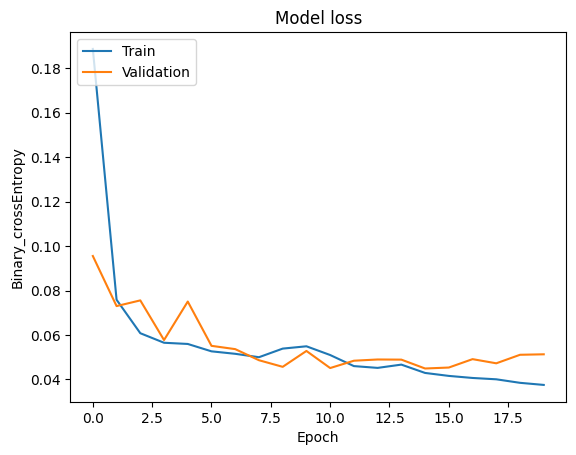

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
print(history.history.keys())


dict_keys(['dice_coef', 'jaccard_index', 'loss', 'val_dice_coef', 'val_jaccard_index', 'val_loss'])


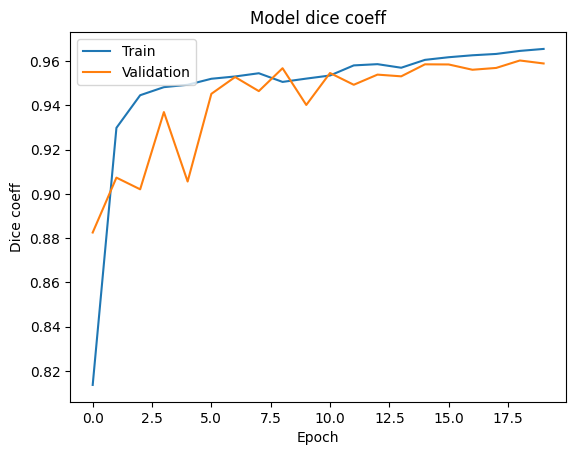

In [24]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

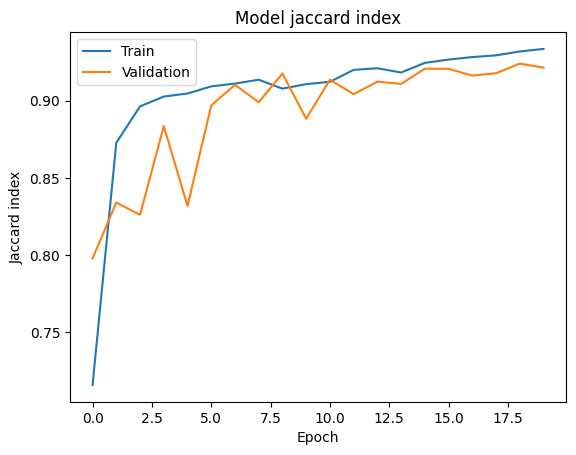

In [25]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Testing**

# **Checking test shape**

In [26]:
print(X_test.shape)
r_x_test = X_test
print(r_x_test.shape)

(266, 512, 512, 3)
(266, 512, 512, 3)


# **Loading Model Weights and Predicting Test Data in Keras**

In [28]:
# Load pre-trained model weights from the specified file
model.load_weights('./model.keras')

# Predict the output for the test data
# r_x_test: test data, assumed to be preprocessed input images
test_preds = model.predict(r_x_test, batch_size=4)


# Print the shape of the predicted output
# This will give the dimensions of the predictions, which should match the test data in terms of batch size and output shape
print(test_preds.shape)

# Print the type of the predictions object
# This is to confirm the data type of the predictions, which is usually a NumPy array after model prediction
print(type(test_preds))


67/67 ━━━━━━━━━━━━━━━━━━━━ 72s 626ms/step
(266, 512, 512, 3)
<class 'numpy.ndarray'>


# **Inspecting Prediction Attributes and Visualizing Results**

<class 'numpy.ndarray'>
(266, 512, 512, 3)
float32


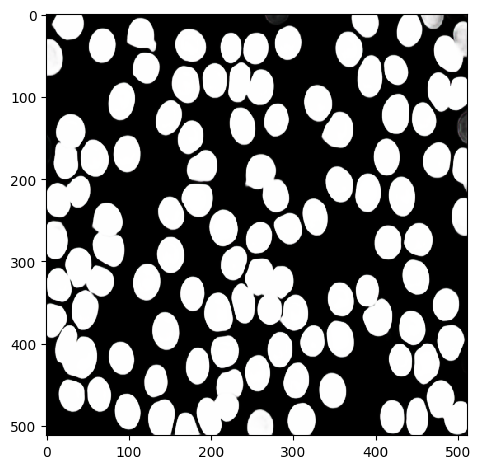

In [29]:
# Print the data type of the predicted results
print(type(test_preds))

# Print the shape of the predicted output
# This will give the dimensions of the predictions, such as (batch_size, height, width, n_classes)
print(test_preds.shape)

# Print the data type of the elements in the predicted array
# This helps to verify the numerical type, e.g., float32, which is often the default for model predictions
print(test_preds.dtype)

# Visualize the first predicted output using imshow
imshow(test_preds[0])

# **Visualizing Predicted and Ground Truth Image Collections**

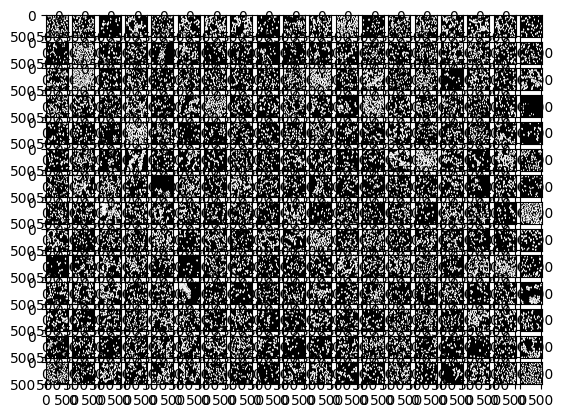

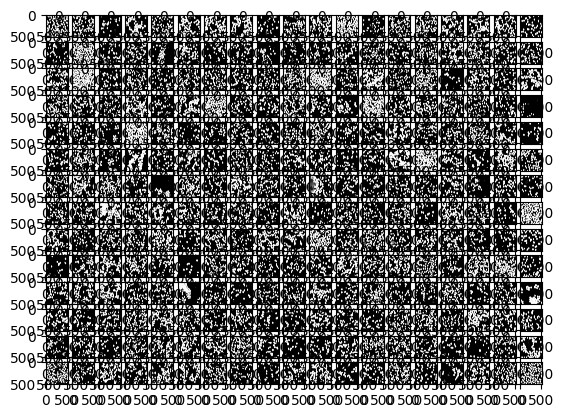

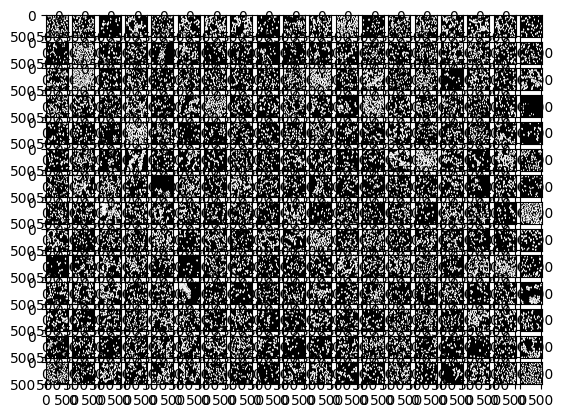

In [30]:
# Import the imshow_collection function from skimage to display a collection of images
from skimage.io import imshow_collection

# Display the collection of predicted images (test predictions)
imshow_collection(test_preds)

# Display the collection of ground truth images for comparison
imshow_collection(y_test)

# **Computing Dice Coefficient and Jaccard Index for Mask Evaluation**

In [31]:
# Dice Coefficient for individual evaluation
# This function computes the Dice Coefficient between two tensors (ground truth and predicted masks)
def dice_coef2(a, b):
    # a: Ground truth mask (scaled down by 255)
    # b: Predicted mask

    # Normalize the ground truth mask by dividing by 255
    hi = a / 255
    pred = b

    # Flatten both ground truth and predicted masks to perform element-wise operations
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator: 2 * intersection between ground truth and predicted masks
    upper_part = 2 * tf.keras.backend.sum(hi * pred)

    # Calculate the denominator: sum of ground truth and predicted masks
    lower_part = tf.keras.backend.sum(hi + pred)

    # Dice Coefficient formula
    dice = upper_part / lower_part

    return dice

# Jaccard Index (IoU) for individual evaluation
# This function computes the Jaccard Index (IoU) between two tensors (ground truth and predicted masks)
def jaccard_index2(a, b):
    # a: Ground truth mask (scaled down by 255)
    # b: Predicted mask

    # Normalize the ground truth mask by dividing by 255
    hi = a / 255
    pred = b

    # Flatten both ground truth and predicted masks
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator: intersection between ground truth and predicted masks
    numerator = tf.keras.backend.sum(hi * pred)

    # Calculate the denominator: union of ground truth and predicted masks
    denominator = tf.keras.backend.sum(hi + pred - hi * pred)

    # Jaccard Index formula
    iou = numerator / denominator

    return iou

Data type of ground truth mask (y_test[0]): uint8
Data type of predicted mask (test_preds[0]): float32
Dice Coefficient: tf.Tensor(0.94085175, shape=(), dtype=float32)
Jaccard Index: tf.Tensor(0.88830984, shape=(), dtype=float32)


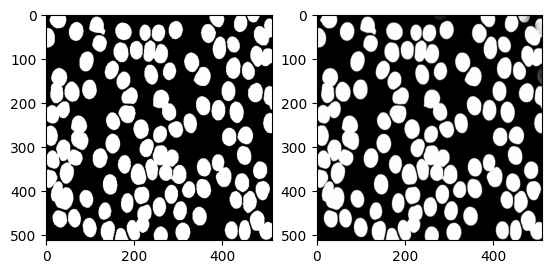

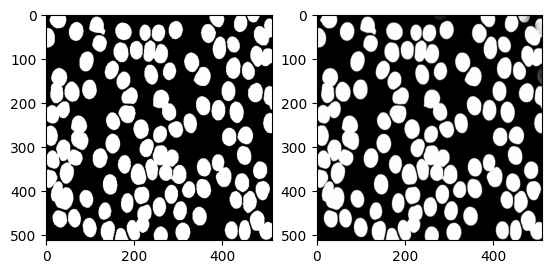

In [32]:
from skimage.io import imshow_collection
# Print the data types of the ground truth and predicted masks for verification
print("Data type of ground truth mask (y_test[0]):", y_test[0].dtype)
print("Data type of predicted mask (test_preds[0]):", test_preds[0].dtype)

# Select the first ground truth and predicted masks for evaluation
i = y_test[0]  # Ground truth mask
j = test_preds[0]  # Predicted mask

# Subheading: Computing the Dice Coefficient and Jaccard Index

# Compute the Dice Coefficient between the ground truth and predicted masks
result = dice_coef2(i, j)
print('Dice Coefficient:', result)

# Compute the Jaccard Index between the ground truth and predicted masks
result2 = jaccard_index2(i, j)
print('Jaccard Index:', result2)



# Create an array to hold the ground truth and predicted masks for visualization
x = np.zeros((2, row, columns, 3))  # Shape to hold two images: ground truth and predicted
x[0] = i  # Ground truth mask
x[1] = j  # Predicted mask

# Visualize the ground truth and predicted masks side by side using imshow_collection
imshow_collection(x)  # Display both masks (ground truth and prediction) for comparison

# **Calculating Average Dice Coefficient and Jaccard Index for Test Dataset**

In [33]:
# Initialize variables to hold the sum of Dice Coefficient and Jaccard Index values
avg_dice = 0  # Variable to accumulate Dice Coefficient values
avg_jaccard = 0  # Variable to accumulate Jaccard Index values

# Subheading: Calculating Metrics for Each Test Sample

# Loop through all the test samples to compute the Dice Coefficient and Jaccard Index
for x in range(len(test_preds)):
    i = y_test[x]  # Ground truth mask for the x-th test sample
    j = test_preds[x]  # Predicted mask for the x-th test sample
    
    # Compute Dice Coefficient and Jaccard Index for the current sample and accumulate the results
    avg_dice += tf.get_static_value(dice_coef2(i, j))  # Add current Dice Coefficient to the total sum
    avg_jaccard += tf.get_static_value(jaccard_index2(i, j))  # Add current Jaccard Index to the total sum



# Calculate the average Dice Coefficient and Jaccard Index by dividing by the number of test samples
avg_dice = avg_dice / len(test_preds)
avg_jaccard = avg_jaccard / len(test_preds)



# Print the average Dice Coefficient and Jaccard Index for the test dataset
print('Average Test Dice Coefficient:', avg_dice)
print('Average Test Jaccard Index:', avg_jaccard)

Average Test Dice Coefficient: 0.9282824674943336
Average Test Jaccard Index: 0.8668534155178788


# **Evaluating Model Performance: Loss, Dice Coefficient, and Jaccard Index**

In [34]:
# Print the lowest training loss during model training
print('Lowest training loss:', min(history.history['loss']))

# Print the lowest validation loss during model validation
print('Lowest validation loss:', min(history.history['val_loss']))

# Subheading: Printing Highest Dice Coefficient

# Print the highest training Dice Coefficient achieved during training
print('Highest training Dice Coefficient:', max(history.history['dice_coef']))

# Print the highest validation Dice Coefficient achieved during validation
print('Highest validation Dice Coefficient:', max(history.history['val_dice_coef']))



# Print the highest training Jaccard Index achieved during training
print('Highest training Jaccard Index:', max(history.history['jaccard_index']))

# Print the highest validation Jaccard Index achieved during validation
print('Highest validation Jaccard Index:', max(history.history['val_jaccard_index']))

Lowest training loss: 0.03750148415565491
Lowest validation loss: 0.044893547892570496
Highest training Dice Coefficient: 0.9654617309570312
Highest validation Dice Coefficient: 0.9602392315864563
Highest training Jaccard Index: 0.9335183501243591
Highest validation Jaccard Index: 0.9239736795425415
